# Liquid-liquid equilibrium prediction
## Context
### When working with enzymatic reactions, liquid-liquid equilibrium mediums are quite common, because of this, it is crutial to determine the components distribution within the two liquid phases
### With this distribution deciphered one can predict the kinetic behaviours of the reaction
### Due to the high nonideality of the reactive biphasic systems, this code will utilize thermodinamic concepts, such as component activities, to predict the components distribution
### For more information on how this reactive systems work and it's limitations, feel free to read the following paper
[UNIFAC Evaluation of the Liquid−Liquid Phase Equilibrium during
Lipase-Catalyzed Peracidation of Different Carboxylic Acids](https://pubs.acs.org/doi/full/10.1021/acs.jced.1c00917?casa_token=G7Xk2-8GDb4AAAAA%3AkTkUdQLbssaVddo9Q9Dw00xGc0qk1XP3IzxlTVHypDqmJkijm_qWdfIczc9XuNoj6XnncEtlPDxZ1B4)

## Libraries to import

In [1]:
#with this code, the goal is to predict the distribution of components within a mixture that is in liquid-liquid equilibrium
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import least_squares
from thermo.unifac import UNIFAC, UFSG, UFIP
from thermo.chemical import Chemical
from ugropy import Groups
import phasepy
from phasepy import mixture, component, virialgamma,unifac
from phasepy.equilibrium import lle
from thermo.unifac import UNIFAC_group_assignment_DDBST
import pubchempy as pcp
import math
from thermo.unifac import DOUFSG, DOUFIP2016, PSRKSG, PSRKIP
import re

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19


## Data insertion
### Here you insert the experimental data you want to simulate to predict it's biphasic behaviour, it is important to consider the following things:
1. Temperatures in phasepy and thermo are read in Kelvin
2. Pressures in phasepy are read in Bars, but in Pascals when working with thermo
3. All components, substrates, products and solvents must be handed in a single list


In [10]:
#first we define the system conditions in which we are operating
T=25+273.15   #temperature in Kelvin
P=1.01325     #pressure in bar
#next, we need to define the components in our experiments
components=[['acetic acid','hydrogen peroxide','water','diisopropyl ether'],['acetic acid','hydrogen peroxide','water','toluene'],['acetic acid','hydrogen peroxide','water','heptane'],['lauric acid','hydrogen peroxide','water','diisopropyl ether'],['lauric acid','hydrogen peroxide','water','toluene'],['lauric acid','hydrogen peroxide','water','heptane']]
components_initial_values=[[[2.6123,'mass'],[4.125,'mass'],[12.375,'mass'],[17.8883,'mass']],[[0.7502,'mass'],[4.125,'mass'],[12.375,'mass'],[21.5978,'mass']],[[1.0420,'mass'],[4.125,'mass'],[12.375,'mass'],[17.0384,'mass']],[[2.5049,'mass'],[4.125,'mass'],[12.375,'mass'],[17.8883,'mass']],[[2.5081,'mass'],[4.125,'mass'],[12.375,'mass'],[21.6435,'mass']],[[2.5058,'mass'],[4.125,'mass'],[12.375,'mass'],[17.0384,'mass']]] #list of values of each component, which can be given in 'mass' or 'moles'


## Molar fractions determination
### This code determines the global molar fraction of each component in the system, being able to recieve quantities in mass(g) or moles
### It is important to note that when working in biphasic systems in equilibrium they are three different molar fractions, as an example, take the following molar fractions of a component "i"
$$
Z_i=0.5
$$
$$
X_i^I=0.05
$$
$$
X_i^{II}=0.75
$$
### In this case, the former component represents 50% of the moles present in the system, however, one can see that once distributed in the biphasic system, it is mostly concentrated in the second phase(75% of the moles present in it) in comparison to the first equilibrium phase(only 5%)
### This function helps to determine the global molar fraction, in other words, the concentrations one has before any reaction or biphasic distribution ocurrs(initial conditions)

In [2]:
def get_molar_fractions_zi(components,components_initial_values,T,P):
    components_moles=[]
    for i in range(len(components_initial_values)):
        if components_initial_values[i][1]=='moles':
            components_moles.append(components_initial_values[i][0])
        elif components_initial_values[i][1]=='mass':
            component=Chemical(components[i],T=T,P=P*100000)  #convert pressure to Pa for chemical
            component_molar_mass=component.MW
            components_moles.append(components_initial_values[i][0]/component_molar_mass)
        else:
            raise ValueError("invalid unit for component initial values. Use 'mass' or 'moles'")
    total_moles=sum(components_moles)
    molar_fraction_zi=[moles/total_moles for moles in components_moles]
    return molar_fraction_zi

## Component properties 
### This code uses the phasepy library to predict the phases distributions in equilibrium, this library requires that each component is defined as an object with the following structure
$$
component_i=component(name,T_c,P_c,Z_c,V_c,w,GC)
$$
### Where the name corresponds to the component's name. $T_c$, $P_c$, $Z_c$, $V_c$, and $w$ correspond to the critical temperature, critical pressure, critical fluid compresibility, critical volume and the acentric factor of the component, respectively
### The last input that phasepy requires to define a component class is it's chemical subgroups, this is specifically the chemical subgroups fragmentation of the component based on the UNIFAC(or dortmund) fragmentation guidelines
### To obtain all this characteristics the thermo and pubchempy libraries will be used, where one must specify the pressure and temperature of operation to obtain the most precise data possible, it is crutial to note that not all components have their subgroup fragmentation correctly documented in the DDBST databanks
### To learn more about the libraries being used feel free to read their documentation
[PhasePy](https://github.com/gustavochm/phasepy/tree/master)
###
[thermo](https://thermo.readthedocs.io/index.html#)
###
[PubChempy](https://pubchempy.readthedocs.io/en/latest/)

In [3]:
def get_components_properties_alternative(components,T,P,model_to_use):
    #this function will return a list containing the properties of each component that are needed to define a component using phasepy
    components_properties=[]
    for i in range(len(components)):
        component=Chemical(components[i],T=T,P=P*100000)   #convert pressure to Pa for chemical
        properties=[component.Tc,component.Pc/100000,component.Zc,component.Vc*1000000,component.omega]
        component_name=components[i]
        compound = pcp.get_compounds(component_name, 'name')[0]
        synonyms = compound.synonyms
        cas_pattern = r'^\d{2,7}-\d{2}-\d$'
        cas_numbers = [syn for syn in synonyms if re.match(cas_pattern, syn)]
        if len(cas_numbers)>0:
           cas_to_use=cas_numbers[0]
        else:
            cas_to_use=None
        if model_to_use=="UNIFAC":
            subgroups_example = UNIFAC_group_assignment_DDBST(CAS=cas_to_use, model="UNIFAC")
            subgroups_named = {str(UFSG[idx])[1:-1]: count for idx, count in subgroups_example.items()}
        elif model_to_use=="MODIFIED_UNIFAC":
            subgroups_example=UNIFAC_group_assignment_DDBST(CAS=cas_to_use, model="MODIFIED_UNIFAC")
            subgroups_named={str(DOUFSG[idx])[1:-1]: count for idx, count in subgroups_example.items()}
        elif model_to_use=="PSRK":
            subgroups_example=UNIFAC_group_assignment_DDBST(CAS=cas_to_use, model="PSRK")
            subgroups_named={str(PSRKSG[idx])[1:-1]: count for idx, count in subgroups_example.items()}
        else:
            raise ValueError("invalid model to use. Use 'UNIFAC', 'MODIFIED_UNIFAC' or 'PSRK'")
        properties.append(subgroups_named)
        components_properties.append(properties)
    return components_properties



## Components setup
### This function recieves the properties obtained from the previous function to define the components as the phasepy object

In [4]:
#Now that we have the functions to facilitate obtaining the properties needed to define the liquid-liquid equilibrium, we can start defining our system
def set_components(components,components_properties):
    mixtures_to_use=[]
    for i in range(len(components)):
        component_to_add=component(name=components[i],Tc=components_properties[i][0],Pc=components_properties[i][1],Zc=components_properties[i][2],Vc=components_properties[i][3],w=components_properties[i][4],GC=components_properties[i][5])
        mixtures_to_use.append(component_to_add)
    return mixtures_to_use

## Example
### The following line of code shows how to setup a system, it is important to note that one must verify if all components to evaluate have the subgroups fragmentation in the databank, since you will need to insert it's subgroups manually if chemical subgroup fragmentation isn't available

In [11]:
#Now we will define our mixture
#specific example where hydrogen peroxide's subgroups are not avilable in the databank
for j in range(len(components)):
    components_to_evaluate=components[j]
    components_initial_values_to_evaluate=components_initial_values[j]
    experiment_molar_fractions=get_molar_fractions_zi(components_to_evaluate,components_initial_values_to_evaluate,T,P)
    component_properties=get_components_properties_alternative(components_to_evaluate,T,P,"MODIFIED_UNIFAC")
    component_properties[1][5]={'OH':2}
    mixture_to_use=set_components(components_to_evaluate,component_properties)   
    #now we can define the mixture using phasepy
    mix=mixture(mixture_to_use[0],mixture_to_use[1])
    for i in range(2,len(mixture_to_use)):
       mix.add_component(mixture_to_use[i])
    #now we define the unifac model to be used
    mix.original_unifac()
    eos=virialgamma(mix, actmodel='original_unifac')
    T=T
    P=P
    Z=np.array(experiment_molar_fractions)
    x0=np.array([0.02,0.1,0.85,0.03])
    w0=np.array([0.05,0.2,0.35,0.4])
    lle(x0,w0,Z,T,P,eos,full_output=True)




In [ ]:
#Now we will define our mixture
#general example
for j in range(len(components)):
    components_to_evaluate=components[j]
    components_initial_values_to_evaluate=components_initial_values[j]
    experiment_molar_fractions=get_molar_fractions_zi(components_to_evaluate,components_initial_values_to_evaluate,T,P)
    component_properties=get_components_properties_alternative(components_to_evaluate,T,P,"MODIFIED_UNIFAC")
    try:
       mixture_to_use=set_components(components_to_evaluate,component_properties)   
    except Exception as e:
       print("An error has ocurred, most likely due to a missing subgroup in the databank")
       for idx, prop in enumerate(component_properties):
          if not prop[5]:
             subgroup_to_add=input(f"Insert subgroups for '{components_to_evaluate[idx]}' as a python dict")
             component_properties[idx][5]=eval(subgroup_to_add)
       mixture_to_use=set_components(components_to_evaluate,component_properties)

          
    #now we can define the mixture using phasepy
    mix=mixture(mixture_to_use[0],mixture_to_use[1])
    for i in range(2,len(mixture_to_use)):
       mix.add_component(mixture_to_use[i])
    #now we define the unifac model to be used
    mix.original_unifac()
    eos=virialgamma(mix, actmodel='unifac')
    T=T
    P=P
    Z=np.array(experiment_molar_fractions)
    x0=np.array([0.02,0.1,0.85,0.03])
    w0=np.array([0.05,0.2,0.35,0.4])
    lle(x0,w0,Z,T,P,eos,full_output=True)

## Extra conversion
### Phasepy will return the molar fractions for each component in each phase, if you desire to evaluate mass fractions instead, you can use the following function

In [5]:
def molar_fraction_to_mass_fraction(components,molar_fractions,T,P):
    #this function assumes a calculus base of 1 mole of the mixture
    components_mass=[]
    for i in range(len(components)):
        component=Chemical(components[i],T=T,P=P*100000)  #convert pressure to Pa for chemical
        component_molar_mass=component.MW
        component_mass=molar_fractions[i]*component_molar_mass
        components_mass.append(component_mass)
    total_mass=sum(components_mass)
    mass_fractions=[mass/total_mass for mass in components_mass]
    return mass_fractions
        

## Example

In [12]:
aquous_phase=molar_fraction_to_mass_fraction(components[0],[0.03648281, 0.14503408, 0.81393171, 0.0045514],T,P)
organic_phase=molar_fraction_to_mass_fraction(components[0],[0.0663435 , 0.0083959 , 0.07846759, 0.846793],T,P)
print(aquous_phase)
print(organic_phase)

[0.09845519813479246, 0.2216969081999439, 0.6589495525424633, 0.020898341122800174]
[0.04320909796149819, 0.003097300059743869, 0.015331369996393883, 0.938362231982364]


## Equilibrium constants
### When working with a reactive system, one can obtain the equilibrium constant, which is defined as the state in which  the thermodinamic equilibrium is reached, in other words, when the Gibbs energy of reaction equals to 0.
### In order to obtain this constant, one can use the following formula
$$
K_a=\prod a_i^{\nu_i}
$$
### Where $a_i$ corresponds to the component's activity and $\nu_i$ corresponds to the stechiometric coefficient of the component in the reaction
### It is important to note that one must determine in which phase the reaction ocurrs, since activity is given by the following formula
$$
a_i=x_i\gamma_i
$$
### Where $x_i$ corresponds to the molar fraction and $\gamma_i$ corresponds to the activity coefficient of i

## Activity coefficients
### The following function calculates the activity coefficients of all components present in the liquid-liquid equilibrium system
### It requires the molar fractions, which should be the ones where the reaction is ocurring, the chemical subgroups of each species and which thermodinamic model you want to use
### Tip: read the thermo documentation linked above if you wish to know what each databank contains

In [6]:
#this is the most crucial function of the code, it uses the thermo library to obtain the chemical subgroups present in each component and then uses the UNIFAC model of ones choosing to calculate the activity coefficients of each component in each experiment
def get_activity_coefficients(components_present,molar_fractions,chemical_subgroups,T,P,model_to_use):
    #This function will return a list of activity coefficients for each component in each experiment
    activity_coefficients=[]
    #first we must define the chemical subgroups of every component
    #now that we have the chemical subgroups of each component and the molar fractions of each component in each experiment, we can get the activity coefficients for each one
    if model_to_use=="UNIFAC":
        model=UNIFAC.from_subgroups(T=T,xs=molar_fractions,chemgroups=chemical_subgroups,subgroups=UFSG,interaction_data=UFIP,version=0)
    elif model_to_use=="MODIFIED_UNIFAC":
        model=UNIFAC.from_subgroups(T=T,xs=molar_fractions,chemgroups=chemical_subgroups,subgroups=DOUFSG,interaction_data=DOUFIP2016,version=1)
    elif model_to_use=="PSRK":
        model=UNIFAC.from_subgroups(T=T,xs=molar_fractions,chemgroups=chemical_subgroups,subgroups=PSRKSG,interaction_data=PSRKIP,version=2)
    else:
        raise ValueError("Model not recognized, please use 'UNIFAC','MODIFIED_UNIFAC' OR 'PSRK'")
           
    activity_coeffs=model.gammas()
        #we append the activity coefficients of each component of the experiment in the list
    activity_coefficients.append(activity_coeffs)  #we append the experiment number and the corresponding activity coefficients of each component
    return activity_coefficients

In [7]:
def calculate_equilibrium_constant(stech_coeffs,molar_fracs,activity_coeffs):
    #this function will create a list of equilibrium constants for each reaction
    eq_constants=[]
    #this function will assume that you hand in the stechiometry coeffs, the activity coeffs and the molar fractions in order
    for i in range(len(stech_coeffs)):
        k_values=[]
        for j in range(len(stech_coeffs[i])):
            component_activity=(molar_fracs[i][j]*activity_coeffs[i][j])**stech_coeffs[i][j]
            k_values.append(component_activity)
        eq_constants.append(math.prod(k_values))
    return eq_constants

## Example
### The following code shows the basic order one can follow to obtain the equilibrium constant, where the main dificulty comes from needing to convert the subgroup names to their corresponding indexes to calculate the activity coefficients

In [14]:
#Now to finalize, we will calculate the equilibrium constant of each system
#we will follow the basic formula to obtain equilibrium constants, where activity coefficients, stechiometric coefficients and molar fractions are needed
all_components_present=['acetic acid','hydrogen peroxide','water','peracetic acid','diisopropyl ether']
stechiometric_coeffs=[-1,-1,1,1]    #stechiometric coeffs that correspond to each reaction
molar_fractions=[0.0139,0.0187,0.2668,0.6996,0.001]
component_properties=get_components_properties_alternative(all_components_present,T,P,"MODIFIED_UNIFAC")
component_properties[1][5]={'OH':2}
component_properties[3][5]={'CH3':1,'CH3CO':1,'C2H5O2':1}
subgroups=[]
for i in range(len(component_properties)):
    subgroups.append(component_properties[i][5])
subgroup_dict = UFSG        #we obtain the subgroup dictionary from the UNIFAC model
name_to_index = {str(v)[1:-1]: k for k, v in subgroup_dict.items()}  #subgroup_dict.items() will give us the index of each subgroup, where we then create a dict with the index and subgroup name of each component in the UNIFAC databank, where [1:-1] is just used to remove the < and > symbols from the subgroup names
indexed_subgroups = []
for group_dict in subgroups:       #for each subgroup present in the component properties
    indexed_group_dict = {}
    for group_name, count in group_dict.items():    #for each pair of subgroup name and count
        if group_name in name_to_index:             # f the subgroup name is present in the UNIFAC databank
            index = name_to_index[group_name]       # obtain the index of the subgroup in the databank
            indexed_group_dict[index] = count       #obtain the ammount of subgroups present in the component
        else:
            raise ValueError(f"Group name '{group_name}' not found in the subgroup dictionary.")
    indexed_subgroups.append(indexed_group_dict)
print(indexed_subgroups)
activity_coeffs=get_activity_coefficients(all_components_present,molar_fractions,indexed_subgroups,T,P,'UNIFAC')
print(activity_coeffs)
molar_fractions=[molar_fractions]
stechiometric_coeffs=[stechiometric_coeffs]
equilibrium_activities=calculate_equilibrium_constant(stechiometric_coeffs,molar_fractions,activity_coeffs)
print(equilibrium_activities)        



[{1: 1, 42: 1}, {14: 2}, {16: 1}, {1: 1, 18: 1, 100: 1}, {1: 4, 3: 1, 26: 1}]
[[0.4921697440493018, 1.4163471077638106, 0.7440804038300262, 0.9512423076071421, 9.448110304077035]]
[729.1311153900114]


## Plotting
### The following line of code is to show how to plot the molar distribution of a component in the two phases, along with a simple way to tabulate important values, such as the molar fractions, activity coefficients and equilibrium constants

C:\Users\esteb\AppData\Local\Temp\ipykernel_2220\1363455399.py:52: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)  # Make sure y axis starts at zero


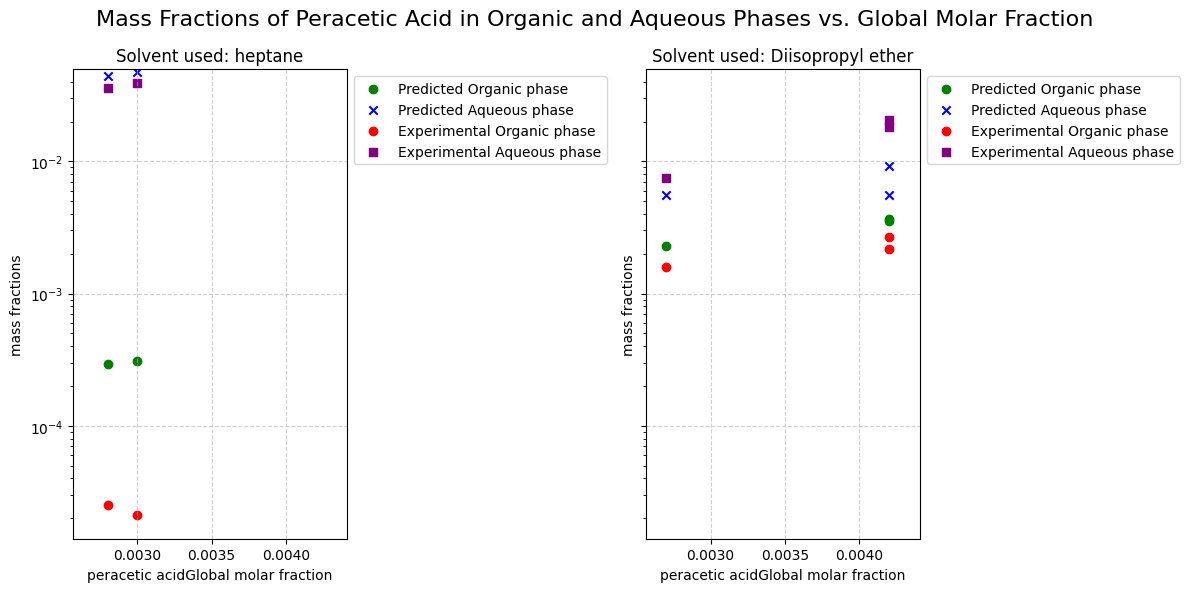

In [26]:
#First we will plot the molar fractions of a product of interest under different substrate molar fractions
components=[['acetic acid','hydrogen peroxide','water','heptane','peracetic acid'],['acetic acid','hydrogen peroxide','water','Diisopropyl ether','peracetic acid']]
global_molar_fractions=[[[0.02,0.0028,0.193,0.782,0.0022],[0.0192,0.0025,0.1932,0.782,0.003],[0.0194,0.0025,0.1933,0.782,0.0028]],[[0.0188,0.026,0.1636,0.7889,0.0027],[0.0172,0.0288,0.1644,0.7855,0.0042],[0.0173,0.0119,0.1755,0.7911,0.0042]]]
experimental_mass_fractions_organic=[[1.4*10**(-5),2.1*10**(-5),2.5*10**(-5)],[1.59*10**(-3),2.18*10**(-3),2.69*10**(-3)]]
experimental_mass_fractions_aqueous=[[0.0311,0.0391,0.0356],[0.0075,0.0182,0.0207]]
T=30+273.15   #temperature in Kelvin
P=1.01325     #pressure in bar
ncols=2         #number of columns for the subplots
nrows=1  #number of rows for the subplot
fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 6*nrows), sharex=True, sharey=True)  #we create the figure and subplots, defining it's dimensions and in this case the x and y axes will be shared across all subplots to compare them
axs = axs.flatten()   #we flatten the axs array to make it easier to iterate trhough
for j in range(len(components)):
    components_to_evaluate=components[j]
    experiment_fraction_organic=[]
    experiment_fraction_aqueous=[]
    for i in range(len(global_molar_fractions[j])):
        components_molar_fractions_to_use=global_molar_fractions[j][i]
        component_properties=get_components_properties_alternative(components_to_evaluate,T,P,"MODIFIED_UNIFAC")
        component_properties[1][5]={'OH':2}
        component_properties[4][5]={'CH3':1,'CH3CO':1,'C2H5O2':1}
        mixture_to_use=set_components(components_to_evaluate,component_properties)   
        #now we can define the mixture using phasepy
        mix=mixture(mixture_to_use[0],mixture_to_use[1])
        for s in range(2,len(mixture_to_use)):
            mix.add_component(mixture_to_use[s])
        #now we define the unifac model to be used
        mix.original_unifac()
        eos=virialgamma(mix, actmodel='original_unifac')
        T=T
        P=P
        Z=np.array(components_molar_fractions_to_use)
        x0=np.array([0.02,0.1,0.85,0.03,0.0005])
        w0=np.array([0.05,0.2,0.35,0.4,0.0005])
        test=lle(x0,w0,Z,T,P,eos,full_output=True)
        phase_molar_fractions=test['X']
        aqueous_phase_molar_fractions=phase_molar_fractions[0]
        organic_phase_molar_fractions=phase_molar_fractions[1]
        aqueous_mass_fractions=molar_fraction_to_mass_fraction(components_to_evaluate,aqueous_phase_molar_fractions,T,P)
        organic_mass_fractions=molar_fraction_to_mass_fraction(components_to_evaluate,organic_phase_molar_fractions,T,P)
        experiment_fraction_organic.append(organic_mass_fractions[4])  #we append the mass fraction of the product of interest
        experiment_fraction_aqueous.append(aqueous_mass_fractions[4])   #we append the mass fraction of the product of interest in the aqueous phase
    molar_fractions_to_evaluate=[]
    for k in range(len(global_molar_fractions[j])):
        molar_fractions_to_evaluate.append(global_molar_fractions[j][k][4])
    ax=axs[j]      #we determine the current axis to plot
    ax.scatter(molar_fractions_to_evaluate,experiment_fraction_organic, label='Predicted Organic phase',color='green')
    ax.scatter(molar_fractions_to_evaluate,experiment_fraction_aqueous, label='Predicted Aqueous phase',color='blue',marker='x')
    ax.scatter(molar_fractions_to_evaluate,experimental_mass_fractions_organic[j], label='Experimental Organic phase',color='red',marker='o')
    ax.scatter(molar_fractions_to_evaluate,experimental_mass_fractions_aqueous[j], label='Experimental Aqueous phase',color='purple',marker='s')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlim(min(molar_fractions_to_evaluate)*0.95, max(molar_fractions_to_evaluate)*1.05)
    ax.set_ylim(bottom=0)  # Make sure y axis starts at zero 
    ax.set_yscale('log')
    ax.set_xlabel(components[j][4]+"Global molar fraction")
    ax.set_ylabel("mass fractions")
    ax.set_title("Solvent used: "+components[j][3])
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))   #we add the legend to identify which is the predicted and experimental data
    ax.grid(True)
fig.suptitle("Mass Fractions of Peracetic Acid in Organic and Aqueous Phases vs. Global Molar Fraction", fontsize=16)
plt.tight_layout()
plt.show()  #we show the plot

    

## Tabulate example

In [22]:
def print_properties_table(components_to_tabulate,global_molar_fractions,aqueous_phase_mf,organic_phase_mf,activity_coeffs,equilibrium_constant):
    comp_col_width = 27
    zi_col_width = 27
    aqu_frac_col_width = 27
    org_frac_col_width = 27
    gamma_col_width = 27


    print(f"\nMixture: {', '.join(components_to_tabulate)} (Equilibrium constant: {equilibrium_constant:.3f})")
    print(f"| {'Component':^{comp_col_width}} | {'Z_i':^{zi_col_width}} | {'Aqueous phase molar fraction':^{aqu_frac_col_width}} | {'Organic phase molar fraction':^{org_frac_col_width}} | {'Global activity coefficient':^{gamma_col_width}} |")
    print("|---------------------------|---------------------------|---------------------------|---------------------------|---------------------------|")

    number_of_components = len(components_to_tabulate)
    for i in range(number_of_components):
        component_to_evaluate =components_to_tabulate[i]
        global_molar_fraction,aqueous_phase_molar_fraction,organic_phase_molar_fraction,activity_coeff=global_molar_fractions[i],aqueous_phase_mf[i],organic_phase_mf[i],activity_coeffs[i]
        # All numbers are right-aligned, use the same width as the columns
        print(f"| {component_to_evaluate:>{comp_col_width}} | {global_molar_fraction:>{zi_col_width}.3f} | {aqueous_phase_molar_fraction:>{aqu_frac_col_width}.3f} | {organic_phase_molar_fraction:>{org_frac_col_width}.3f} | {activity_coeff:>{gamma_col_width}.3f} |")

    print("|---------------------------|---------------------------|---------------------------|---------------------------|---------------------------|")


In [23]:
#Graphs aren't the best option to visualize the results of this predictions, so now we will create a simple code that will print the results in a table format, detailing the molar fraction in each phase, the activity coefficients and the equilibrium constant
all_components_present=['acetic acid','hydrogen peroxide','water','peracetic acid','diisopropyl ether']
components_global_masses=[[2.6123,'mass'],[4.125,'mass'],[12.375,'mass'],[0.5,'mass'],[17.8883,'mass']]
stechiometric_coeffs=[-1,-1,1,1]    #stechiometric coeffs that correspond to each reaction
T=30+273.15   #temperature in Kelvin
P=1.01325     #pressure in bar
global_molar_fractions=get_molar_fractions_zi(all_components_present,components_global_masses,T,P)
component_properties=get_components_properties_alternative(all_components_present,T,P,"MODIFIED_UNIFAC")
component_properties[1][5]={'OH':2}
component_properties[3][5]={'CH3':1,'CH3CO':1,'C2H5O2':1}
mixture_to_use=set_components(all_components_present,component_properties)   
#now we can define the mixture using phasepy
mix=mixture(mixture_to_use[0],mixture_to_use[1])
for s in range(2,len(mixture_to_use)):
    mix.add_component(mixture_to_use[s])
#now we define the unifac model to be used
mix.original_unifac()
eos=virialgamma(mix, actmodel='original_unifac')
T=T
P=P
Z=np.array(global_molar_fractions)
x0=np.array([0.02,0.1,0.85,0.03,0.0005])
w0=np.array([0.05,0.2,0.35,0.4,0.0005])
test=lle(x0,w0,Z,T,P,eos,full_output=True)
phase_molar_fractions=test['X']
aqueous_phase_molar_fractions=phase_molar_fractions[0]
organic_phase_molar_fractions=phase_molar_fractions[1]
subgroups=[]
for i in range(len(component_properties)):
    subgroups.append(component_properties[i][5])
subgroup_dict = UFSG        #we obtain the subgroup dictionary from the UNIFAC model
name_to_index = {str(v)[1:-1]: k for k, v in subgroup_dict.items()}  #subgroup_dict.items() will give us the index of each subgroup, where we then create a dict with the index and subgroup name of each component in the UNIFAC databank, where [1:-1] is just used to remove the < and > symbols from the subgroup names
indexed_subgroups = []
for group_dict in subgroups:       #for each subgroup present in the component properties
    indexed_group_dict = {}
    for group_name, count in group_dict.items():    #for each pair of subgroup name and count
        if group_name in name_to_index:             # f the subgroup name is present in the UNIFAC databank
            index = name_to_index[group_name]       # obtain the index of the subgroup in the databank
            indexed_group_dict[index] = count       #obtain the ammount of subgroups present in the component
        else:
            raise ValueError(f"Group name '{group_name}' not found in the subgroup dictionary.")
    indexed_subgroups.append(indexed_group_dict)
activity_coeffs=get_activity_coefficients(all_components_present,global_molar_fractions,indexed_subgroups,T,P,'UNIFAC')
stechiometric_coeffs=[stechiometric_coeffs]
global_molar_fractions=[global_molar_fractions]
equilibrium_constant=calculate_equilibrium_constant(stechiometric_coeffs,global_molar_fractions,activity_coeffs)
print_properties_table(all_components_present,global_molar_fractions[0],aqueous_phase_molar_fractions,organic_phase_molar_fractions,activity_coeffs[0],equilibrium_constant[0])




Mixture: acetic acid, hydrogen peroxide, water, peracetic acid, diisopropyl ether (Equilibrium constant: 0.215)
|          Component          |             Z_i             | Aqueous phase molar fraction | Organic phase molar fraction | Global activity coefficient |
|---------------------------|---------------------------|---------------------------|---------------------------|---------------------------|
|                 acetic acid |                       0.042 |                       0.037 |                       0.064 |                       0.879 |
|           hydrogen peroxide |                       0.117 |                       0.144 |                       0.009 |                       1.168 |
|                       water |                       0.665 |                       0.808 |                       0.085 |                       1.463 |
|              peracetic acid |                       0.006 |                       0.006 |                       0.009 |              